# 2CS-SIL2/SIQ2 Lab01. Logistic Regression

<p style='text-align: right;font-style: italic;'>Designed by: Mr. Abdelkrime Aries</p>

In this lab, we will learn all about logistic regression:
- Linear regression
- Binary logistic regression
- Multi-class logistic regression
- Multi-label logistic regression

**Team:**
- **Member 01**: BOUKHETALA Zaineb
- **Member 02**: HADDAD Amira
- **Group**: SIQ2

In [2]:
import sys, timeit
from typing          import Tuple, List, Type
from collections.abc import Callable

sys.version

'3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]'

In [3]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.__version__, pd.__version__, matplotlib.__version__

('1.26.4', '2.2.2', '3.10.0')

In [4]:
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.linear_model    import SGDClassifier
from sklearn.multiclass      import OneVsRestClassifier
from sklearn.multiclass      import OneVsOneClassifier
from sklearn.metrics         import accuracy_score
from sklearn.metrics         import classification_report
from sklearn.metrics         import log_loss

sklearn.__version__

'1.6.1'

In [5]:
# This code is used to filter warnings concerning convergence
# In general, when the maximum number of iterations is not suffisant to converge
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)

## I. Algorithms implementation

1.   List item
2.   List item



In this section, we will try to implement all forms of linear/logistic regression. In fact, those forms are similar and use almost the same algorithms. For example, multi-label LR is actually binary regression with multiple outputs.


**>> Try to use "numpy" which will save a lot of time and effort**

### I.1. Prediction functions

We want to implement all prediction functions used for linear regression, binary logistic regression and Maximum entropy (Logistic regression with softmax).

#### I.1.1. Linear combination

Given an input:
- $X[M, N]$ a matrix of $M$ samples and $N$ features

and some parameters ($theta_0$ is already embedded as the first parameter):
- $\theta[N]$: in case of binary classification
- $\theta[N, L]$: in case of multi-class classification. $L$ is the number of classes/labels.

calculate the output:
- $Z[M]$: each sample has one output (binary)
- $Z[M, L]$: each sample has $L$ outputs (multiple)

each class/label $c$ (in case of binary classification, there is only one label) has an output:
$$Z_c = \sum\limits_{j=0}^{N} \theta_{(c, j)} X_j | X_0 = 1 $$

A more general form:
$$Z = zfn(X, \theta) = X \cdot \theta$$


In [6]:
# TODO: Linear combination
def zfn(X: np.ndarray, Theta: np.ndarray) -> np.ndarray:
  Z = np.dot(X, Theta)
  return Z

X_t     = np.array([[1., 100.],
                    [1., 200.],
                    [1., 300.]]) # 3 samples, 2 features
Theta_t = np.array([0.3, 0.007]) # 2 classes

X_tL = np.array([[0., 0.],
                 [1., 0.],
                 [0., 1.],
                 [1., 1.]]) # 4 samples, 2 features
Theta_tL = np.array([[0.5, 0.1, 0.6],
                     [0.2, 0.3, 0.0]]) # 2 features, 3 classes
# binary, multiple
zfn(X_t, Theta_t), zfn(X_tL, Theta_tL)

(array([1. , 1.7, 2.4]),
 array([[0. , 0. , 0. ],
        [0.5, 0.1, 0.6],
        [0.2, 0.3, 0. ],
        [0.7, 0.4, 0.6]]))

#### I.1.2. Logistic function

Given the linear combination:
- $Z[M]$: each sample has one output (binary)
- $Z[M, L]$: each sample has $L$ outputs (multiple)

We generate prediction probabilities:
- $H[M]$: each sample has one output (binary)
- $H[M, L]$: each sample has $L$ outputs (multiple)

Using the logistic function:
$$H = \sigma(Z) = \frac{1}{1+e^{-Z}}$$

**>> Using numpy arrays, this function works for vectors and matrices**

In [7]:
# TODO: Logistic function
def sgfn(Z: 'np.ndarray[M, L]') -> 'np.ndarray[M, L]':
    Z = np.exp(-Z)
    return 1 / (1+Z)

Z_t = zfn(X_t, Theta_t)
Z_tL = zfn(X_tL, Theta_tL)
# binary, multiple
sgfn(Z_t), sgfn(Z_tL)

(array([0.73105858, 0.84553473, 0.9168273 ]),
 array([[0.5       , 0.5       , 0.5       ],
        [0.62245933, 0.52497919, 0.64565631],
        [0.549834  , 0.57444252, 0.5       ],
        [0.66818777, 0.59868766, 0.64565631]]))

#### I.1.3. Softmax function

Given the linear combination:
- $Z[M, L]$: each sample has $L$ outputs (multiple)

We generate predictions:
- $H[M, L]$: each sample has $L$ outputs (multiple)

Using the softmax function:
$$H = softmax(Z)=\frac{e^Z}{\sum\limits_{k=1}^{L} e^{Z_k}}$$

Basically:
- Calculate $H' = e^Z$
- Then divide $H'$ by the vector $H'$ summed over colums
- numpy automatically transforms a vector $V[M, 1]$ into $V[M]$. So, you have to force a vertical vector using **reshape(-1, 1)**.
- The sum of probabilities in each row must equal 1

In [8]:
def softmaxfn(Z: np.ndarray) -> np.ndarray:
    H = np.exp(Z)
    H = H / H.sum(axis=1).reshape(-1, 1)
    return H

softmaxfn(Z_tL)

array([[0.33333333, 0.33333333, 0.33333333],
       [0.36029662, 0.24151404, 0.39818934],
       [0.34200877, 0.37797814, 0.28001309],
       [0.37797814, 0.28001309, 0.34200877]])

### I.2. Cost functions

We want to implement these cost functions:
- Mean Square Error (MSE): for linear regression
- Binary Cross Entropy (BCE): for binary logistic regression and multi-label logistic regression
- Cross Entropy (CE): for maximum entropy (MaxEnt) algorithm (multi-class logistic regression)


#### I.2.1. Mean Square Error (MSE)

Given the estimated outputs $H[M]$, calculate the error based on the real outputs $Y[M]$.

$$J = MSE(Y, H) = \frac{1}{2M} \sum\limits_{i=1}^{M} (Y - H)^2$$

**>> This is used for linear regression which is applicable only on one output per sample**

In [9]:
# TODO: MSE cost function
def MSEfn(Y: 'np.ndarray[M]',
        H: 'np.ndarray[M]') -> float:
    J = np.mean(np.power(Y-H,2))
    return J/2

H_t = np.array([1. , 1.7, 2.4])
Y_t = np.array([1., 2., 2.5])
MSEfn(Y_t, H_t)

0.016666666666666673

#### I.2.2. Binary Cross Entropy (BCE)

Given the output probabilities:
- $H[M]$: each sample has one output (binary)
- $H[M, L]$: each sample has $L$ outputs (multi-label)

and the real classes:
- $Y[M]$: each sample has one output (binary)
- $Y[M, L]$: each sample has $L$ outputs (multi-label)

The BCE loss for one sample is:
$$BCE(Y^{(i)}, H^{(i)})
= \begin{cases}
- \log(H^{(i)}) & \text{ si } Y^{(i)} = 1\\
- \log(1 - H^{(i)})  & \text{ si } Y^{(i)} = 0
\end{cases}
$$
Since $Y^{(i)} \in \{0, 1\}$, then:

$$ BCE(Y^{(i)}, H^{(i)}) = - Y^{(i)} \log(H^{(i)}) - (1- Y^{(i)}) \log(1 - H^{(i)}) $$

Then, the loss function will be:
$$J = BCE(Y, H) = \frac{-1}{M} \sum\limits_{i=1}^{M} [Y^{(i)} \log(H^{(i)}) + (1- Y^{(i)}) \log(1 - H^{(i)})]$$

**>> practically, a little value epsilon is added into the log to avoid log(0)**

In [10]:
# TODO: BCE loss function
def BCEfn(Y  : 'np.ndarray[M,L]',
        H  : 'np.ndarray[M,L]',
        eps: float = 1e-8   ) -> float:
    J = - np.mean(Y * np.log(H+eps) + (1-Y) * np.log(1-H+eps))
    return J
Y_t = np.array([1., 0., 1.])
H_t = np.array([0.73105858, 0.84553473, 0.9168273 ])

Y_tL = np.array([[1, 0, 1],
                 [1, 1, 0],
                 [1, 1, 1],
                 [0, 0, 1]]) # multilabel
H_tL = np.array([[0.5       , 0.5       , 0.5       ],
                 [0.62245933, 0.52497919, 0.64565631],
                 [0.549834  , 0.57444252, 0.5       ],
                 [0.66818777, 0.59868766, 0.64565631]])

BCEfn(Y_t, H_t, eps=0), BCEfn(Y_t, H_t), BCEfn(Y_tL, H_tL, eps=0), BCEfn(Y_tL, H_tL)

(0.7559612797265517,
 0.7559612499514038,
 0.7112278056068634,
 0.7112277848173427)

#### I.2.3. Cross Entropy (CE)

Given the output probabilities:
- $H[M, L]$: each sample has $L$ outputs (multi-class)

and the real classes:
- $Y[M, L]$: each sample has $L$ outputs (multi-class)

$$J = CE(H, Y) = \frac{-1}{M} \sum\limits_{i=1}^{M} \sum\limits_{c=1}^{L} Y^{(i)}_c \log(H^{(i)}_c)$$

**>> HINT: sum over classes (column), mean over samples**

In [11]:
# TODO: CE loss function
def CEfn(Y: np.ndarray, H: np.ndarray) -> float:
    J = - np.mean(np.sum(Y*np.log(H)))
    J = J/Y.shape[0]
    return J

Y_tL = np.array([[1,0,0],
                 [0,1,0],
                 [0,0,1],
                 [1,0,0]])
H_tL = np.array([[0.33333333, 0.33333333, 0.33333333],
                 [0.36029662, 0.24151404, 0.39818934],
                 [0.34200877, 0.37797814, 0.28001309],
                 [0.37797814, 0.28001309, 0.34200877]])

CEfn(Y_tL, H_tL)

1.1913194530574498

### I.3. Gradients

We want to implement these cost functions' gradients:
- dMSE: for linear regression
- dBCE: for binary logistic regression (the same as dMSE) and multi-label logistic regression (a little different)
- dCE: for maximum entropy (MaxEnt) algorithm (multi-class logistic regression)

**>> Good news: gradients function is the same**


Given the input:
- $X[M, N]$ a matrix of $M$ samples and $N$ features

the real output values:
- $Y[M]$: each sample has one output
- $Y[M, L]$: each sample has $L$ outputs

and the estimated output:
- $H[M]$: each sample has one estimated output
- $H[M, L]$: each sample has $L$ estimated outputs

calculate the gradients:
- $\frac{\partial J}{\partial \theta}[N]$: each feature has one gradient
- $\frac{\partial J}{\partial \theta}[N, L]$: each feature has $L$ gradients

The gradients are calculated as (matrix form):
$$\frac{\partial J}{\partial \theta} = \frac{1}{M} (X^T \cdot (H - Y))$$

---
A BORING CALCULATION (MSE)

$$\frac{\partial MSE}{\partial \theta_j}
= \frac{\partial }{\partial \theta_j} \frac{1}{2M} \sum\limits_{i=1}^{M} (Y^{(i)} - H^{(i)})^2
= \frac{1}{2M} \sum\limits_{i=1}^{M} [\frac{\partial }{\partial \theta_j} (Y^{(i)} - H^{(i)})^2]
= \frac{1}{2M} \sum\limits_{i=1}^{M} [-2 (Y^{(i)} - H^{(i)}) \frac{\partial }{\partial \theta_j} H^{(i)}]
$$

$$\frac{\partial MSE}{\partial \theta_j}
= \frac{1}{M} \sum\limits_{i=1}^{M} [(H^{(i)} - Y^{(i)}) \frac{\partial }{\partial \theta_j} \sum\limits_{k=0}^{N} \theta_k X_k^{(i)}]
= \frac{1}{M} \sum\limits_{i=1}^{M} [(H^{(i)} - Y^{(i)}) \frac{\partial }{\partial \theta_j} \theta_j X_j^{(i)}]
$$
$$\frac{\partial MSE}{\partial \theta_j} = \frac{1}{M} \sum\limits_{i=1}^{M} (H^{(i)} - Y^{(i)}) X_j^{(i)}$$

---
A BORING CALCULATION (BCE)

$$\frac{\partial BCE}{\partial \theta_j}
= \frac{-1}{M} \sum\limits_{i=1}^{M} \frac{\partial}{\partial \theta_j} [Y^{(i)} \log(H^{(i)}) + (1- Y^{(i)}) \log(1 - H^{(i)})]
$$

$$\frac{\partial BCE}{\partial \theta_j}
= \frac{-1}{M} \sum\limits_{i=1}^{M} [ Y^{(i)} \frac{\partial}{\partial \theta_j} \log(H^{(i)}) + (1- Y^{(i)}) \frac{\partial}{\partial \theta_j}\log(1 - H^{(i)})]
$$

$$\frac{\partial BCE}{\partial \theta_j}
= \frac{-1}{M} \sum\limits_{i=1}^{M} [ Y^{(i)} \frac{1}{H^{(i)}} \frac{\partial}{\partial \theta_j} H^{(i)} + (1- Y^{(i)}) \frac{-1}{1-H^{(i)}} \frac{\partial}{\partial \theta_j} H^{(i)})]
= \frac{-1}{M} \sum\limits_{i=1}^{M} \frac{Y^{(i)}-H^{(i)}}{H^{(i)}(1-H^{(i)})} \frac{\partial}{\partial \theta_j} H^{(i)}
$$

$$\frac{\partial H^{(i)}}{\partial \theta_j}
= \frac{\partial \sigma(Z^{(i)})}{\partial Z^{(i)}} \frac{\partial Z^{(i)}}{\partial \theta_j}
= [\sigma(Z^{(i)}) (1-\sigma(Z^{(i)}))]\frac{\partial}{\partial \theta_j} \sum\limits_{k=0}^{N} \theta_k X_k^{(i)}  
= H^{(i)} (1-H^{(i)})  X_j^{(i)}
$$

$$\frac{\partial BCE}{\partial \theta_j}
= \frac{-1}{M} \sum\limits_{i=1}^{M} \frac{Y^{(i)}-H^{(i)}}{H^{(i)}(1-H^{(i)})} [H^{(i)} (1-H^{(i)}) X_j^{(i)}]
$$

$$\frac{\partial BCE}{\partial \theta_j} = \frac{1}{M} \sum\limits_{i=1}^{M} (H^{(i)} - Y^{(i)}) X_j^{(i)}$$


In [12]:
# TODO: Gradients
def dJfn(X: np.ndarray, H: np.ndarray,  Y: np.ndarray) -> np.ndarray:
    return (1/X.shape[0]) * np.dot(X.T, (H - Y))

X_t = np.array([[1., 100.],
                [1., 200.],
                [1., 300.]])
H_t = np.array([1. , 1.7, 2.4])
Y_t = np.array([1., 2., 2.5])

X_tL = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
H_tL = np.array([[0.33333333, 0.33333333, 0.33333333],
                 [0.36029662, 0.24151404, 0.39818934],
                 [0.34200877, 0.37797814, 0.28001309],
                 [0.37797814, 0.28001309, 0.34200877]])
Y_tL = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])


dJfn(X_t, H_t, Y_t), dJfn(X_tL,H_tL, Y_tL)

(array([ -0.13333333, -30.        ]),
 array([[-0.06543131, -0.11961822,  0.18504953],
        [-0.07000327,  0.16449781, -0.09449454]]))

### I.4. Final product

**>> Nothing to code here**

This section is to show how all the previous algorithms are merged into one usefull program.
So, we will use all the previously implemented functions, add some others and implement a class which is easy to use.

#### I.4.1. Gradient descent

This is the simplest version of gradient descent. It iterates until it reaches the maximum iterations.
It takes estimation function, cost function and gradient function as arguments so we can used it for different problems (linear regression, binary logistic regression, etc.). Also known as polymorphism.

In [13]:
# Gradient descent. By default, it is linear regression
def GDfn (X    : 'np.ndarray[M, N]', # Input M samples, N features (obligatory)
          Y    : 'np.ndarray[M, L]', # Output M samples, L classes (obligatory)
          Theta: 'np.ndarray[N, L]', # Parameters (obligatory)
          IT   : int      = 100    , # Maximum number of iterations
          alpha: float    = 0.01   , # Learning rate
          H_fn : Callable = zfn    , # Estimation function
          J_fn : Callable = MSEfn  , # Cost function
          dJ_fn: Callable = dJfn     # Gradient function
         ) -> Tuple[List[np.ndarray], List[float]]:

    costs  = []           # costs history
    Theta  = Theta.copy() # make a copy of the original parameters

    for it in range(IT):
        H  = H_fn (X, Theta) # estimation
        J  = J_fn (Y, H)     # cost
        dJ = dJ_fn(X, H, Y)  # gradients

        costs.append(J) # add cost into history
        Theta = Theta - alpha * dJ # update parameters

    return Theta, costs

X_t = np.array([
    [1, 1, 0.2],
    [1, 2, 0.1],
    [1, 3, 0.4],
    [1, 4, 0.3]
])
Theta_t = np.array([1., 1., 1.])
Y_t = np.array([1, 0, 1, 0])

Theta_new, J_hist = GDfn(X_t, Y_t, Theta_t, IT=5)

Theta_new, J_hist

(array([0.86298175, 0.58991304, 0.96329937]),
 [6.3375,
  5.32767996484375,
  4.48068435059748,
  3.7702582684901684,
  3.174380343989813])

#### I.4.2. Data preparation functions

The function **norm** normalizes the input $X' = \frac{X-\mu}{\sigma}$:
- in case of training data $X_{train}$, the mean and standard deviation are calculated on this data
- in case of test data $X_{test}$, the mean and standard deviation must be those calculated over $X_{train}$ (passed as arguments)

The function **prepare** returns a prepared data:
- if norm=True: data will be normalized; otherwise it will be the same
- if bias=True: a column of 1s will be added into $X$ (it is like adding $\theta_0$)

In [14]:
# normalize X based on the
def normfn(X, mean=None, std=None):
    if (mean is None) or (std is None):
        mean = np.mean(X, axis=0)
        std = np.std(X, axis=0)
    X_norm = np.where(std==0, X, (X - mean)/std)
    return X_norm, mean, std

def preparefn(X, norm=True, bias=True, mean=None, std=None):
    X_pre = X.copy()
    if norm:
        X_pre, mean, std = normfn(X_pre, mean=mean, std=std)
    if bias:
        X_pre = np.append(np.ones((X_pre.shape[0],1)), X_pre ,axis=1)
    return X_pre, mean, std

X_t = np.array([[1, 0.2],
                [2, 0.1],
                [3, 0.4]])

preparefn(X_t), preparefn(X_t, bias=False, mean=np.array([1.5, 0.1]), std=np.array([2, 0.1]))

((array([[ 1.        , -1.22474487, -0.26726124],
         [ 1.        ,  0.        , -1.06904497],
         [ 1.        ,  1.22474487,  1.33630621]]),
  array([2.        , 0.23333333]),
  array([0.81649658, 0.12472191])),
 (array([[-0.25,  1.  ],
         [ 0.25,  0.  ],
         [ 0.75,  3.  ]]),
  array([1.5, 0.1]),
  array([2. , 0.1])))

#### I.4.3.  Missing functions

These are functions which must be implemented before

In [15]:
def vote(H: np.ndarray) -> np.ndarray:
    res = np.zeros(H.shape)
    res[range(len(H)), H.argmax(axis=1)] = 1
    return res

#### I.4.4.  Regression class

In [16]:
class Regression(object):

    def __init__(self, norm=True, bias=True, type='linear'):
        self.norm  = norm
        self.bias  = bias

        # by default linear regression
        self.Hfn : Callable = zfn   # Estimation function
        self.Yfn : Callable = zfn   # Prediction function
        self.Jfn : Callable = MSEfn # Cost function
        self.dJfn: Callable = dJfn  # Gradient function

        if type in ['binary', 'multilabel']:
            self.Hfn = lambda X, Theta : sgfn(zfn(X, Theta))
            self.Yfn = lambda X, Theta : (self.Hfn(X, Theta) >= 0.5).astype(int)
            self.Jfn = BCEfn
        elif type == 'multiclass':
            self.Hfn = lambda X, Theta : softmaxfn(zfn(X, Theta))
            self.Yfn = lambda X, Theta : vote(self.Hfn(X, Theta))
            self.Jfn = CEfn


    def fit(self, X, Y, max_iter=100, alpha=.01) -> List[float]:
        X_pre, self.mean, self.std = preparefn(X, norm=self.norm, bias=self.bias)
        if len(Y.shape) > 1:
            Theta = np.zeros((X_pre.shape[1], Y.shape[1])) #not simple one output regreesion
        else:
            Theta = np.zeros(X_pre.shape[1])
        self.Theta, costs = GDfn(X_pre, Y, Theta, IT=max_iter, alpha=alpha)
        return costs


    # Predictions
    # if prob=True return probbilities
    # else return labels
    def predict(self, X, prob=True):
        X_pre, _, _ = preparefn(X, norm=self.norm, bias=self.bias, mean=self.mean, std=self.std)
        if prob:
            return self.Hfn(X_pre, self.Theta)
        return self.Yfn(X_pre, self.Theta)

X_tn = np.array([[0., 0.], [1., 0.], [0., 1.], [1., 1.]])
Y_tn = np.array([[1,0,0], [0,1,0], [0,0,1], [1,0,0]])

X_testn = np.array([[2., 2.], [1., 0.], [1., -1.], [2., 5.]])

maxent = Regression(type='multiclass')
_ = maxent.fit(X_tn, Y_tn)
maxent.predict(X_testn, prob=False)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## II. Application and Analysis

In this section, we will test different concepts by running an experiment, formulating a hypothesis and trying to justify it.



In [22]:
grades = pd.read_csv('data/grades.csv')

# Extraction des caractéristiques
Xgrades = grades.iloc[:, :-1].values # Premières colonnes, selecting all columns except the last
Ygrades = grades.iloc[:,  -1].values # Dernière colonne

Xgrades_norm = Xgrades/20 # Nous savons le maximum

grades.head()

,G1,G2,Admitted
0,9.75,16.00,1
1,2.25,9.50,0
2,4.50,2.50,0
3,15.50,10.25,1
4,3.25,19.50,1


In [23]:
# https://www.kaggle.com/datasets/kukuroo3/body-performance-data
body = pd.read_csv('data/bodyPerformance.csv')
body['gender'] = (body['gender'] == 'M').astype(int)  #encoding
body.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,1,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,1,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,1,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,1,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,1,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [24]:
Xbody = body.iloc[:, :-1].values # First columns
Ybody = body.iloc[:,  -1].values # Last column

Xbody_train, Xbody_test, Ybody_train, Ybody_test = train_test_split(Xbody, Ybody,
                                                                    test_size   =0.2, # 20% for test
                                                                    random_state=0,
                                                                    stratify    =Ybody) # stratification This prevents the scenario where one set is over-represented by certain classes, which can lead to biased model performance and evaluation.
scaler = StandardScaler()

Xbody_train = scaler.fit_transform(Xbody_train)
Xbody_test  = scaler.transform(Xbody_test)

Xbody_train.shape, Xbody_test.shape

((10714, 11), (2679, 11))

### II.1. Binary Logistic Regression

We want to test the pupose of:
- Bias parameter
- Data normalization
- Learning rate

So, we run a series of experiments.


In [25]:
# This function will be used to draw a decision boundary given a model
# model: binary clasification model
# ax: an object of type matplotlib.axes.Axes; the axes on which we will draw
# xrange: a list of points on the X axis (the first feature)
# yrange: a list of points on the Y axis (the second feature)
# color: the color of the decision boundary
# label: the label of the decision boundary
def draw2D(model, ax, xrange, yrange, color='red', label=''):
    # Create a matrix of (xrange X yrange): our drawing map
    XX   = [[[xr, yr] for xr in xrange] for yr in yrange]
    # Represent it as a matrix [(xrange X yrange)/2 samples, 2 features]
    XX   = np.array(XX).reshape(-1, 2)
    # Predict the probabilities (estimation) et retransform them into our map (xrange X yrange)
    grid = model.predict(XX).reshape(len(xrange), len(yrange))
    # Draw the lines which cross the value 0.5
    cs   = ax.contour(xrange, yrange, grid, colors=[color], linewidths=(1), linestyles=('-'),levels=[0.5])
    # Assign the label to the boundary
#     plt.clabel(cs, inline=1, fontsize=10)
#     cs.collections[0].set_label(label)
    fmt = {cs.levels[0]: label}
    ax.clabel(cs, cs.levels, inline=True, fmt=fmt, fontsize=14)

print('DONE')

DONE


#### II.1.1. Bias

We want to test what the bias really does (why it is useful)
To this end, we took a linearly separated problem: a student is admitted if the average of the grades is higher or equals 10.

Because the results can be plotted, we will validate the models visually.
For this, we trained two models:
- **Plain**: without a bias
- **Bias**: with a bias

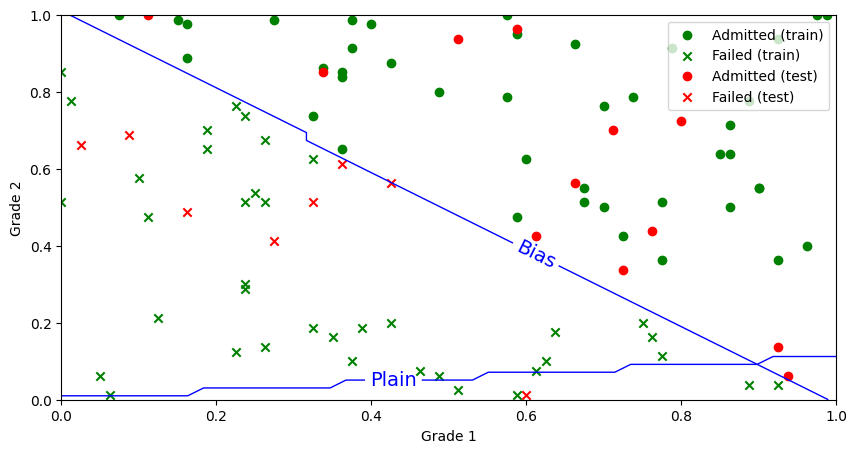

In [26]:

Xgrades_train = Xgrades_norm[:80, :]
Xgrades_test  = Xgrades_norm[80:, :]
Ygrades_train = Ygrades[:80   ]
Ygrades_test  = Ygrades[80:   ]

yes_train = Ygrades_train == 1
yes_test  = Ygrades_test  == 1

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(Xgrades_train[yes_train, 0],
           Xgrades_train[yes_train, 1],
           color='green', marker='o', label='Admitted (train)')
ax.scatter(Xgrades_train[~yes_train, 0],
           Xgrades_train[~yes_train, 1],
           color='green', marker='x', label='Failed (train)')
ax.scatter(Xgrades_test[yes_test, 0],
           Xgrades_test[yes_test, 1],
           color='red', marker='o', label='Admitted (test)')
ax.scatter(Xgrades_test[~yes_test, 0],
           Xgrades_test[~yes_test, 1],
           color='red', marker='x', label='Failed (test)')



# Create grades space: btween 0 and 1 (normalized) with a resolution of 50
xrange = np.linspace(0, 1, 50) # Grade 1
yrange = np.linspace(0, 1, 50) # Grade 2

# Dessiner la ligne de séparation dans une régression linéaire
LR_plain = LogisticRegression(penalty=None, fit_intercept=False)
LR_plain.fit(Xgrades_train, Ygrades_train)
draw2D(LR_plain, ax, xrange, yrange, label='Plain', color='blue')

LR_bias = LogisticRegression(penalty=None)
LR_bias.fit(Xgrades_train, Ygrades_train)
draw2D(LR_bias, ax, xrange, yrange, label='Bias', color='blue')



plt.xlabel('Grade 1')
plt.ylabel('Grade 2')
plt.legend(loc='upper right')
plt.show()

**TODO: Analyze the results**

1. Describe the results (what do you notice?)
2. Discuss the effect of bias in this particular example (How it effects the decision boundary)

**Answers**

1. the plain model is highly inaccurate even on the training dataset, since its without bias, it's constrained to pass through the origin, whereas the bias model is more flexible and is able to seperate the classes (admitted and failed) on both the training and the test set
2. For our linearly separable data, the bias term enhanced separation,which results in a precise, simple, and accurate decision boundary, in most real-world applications, using bias is essential for improving classification performance, and the decision boundary can be shifted to a more optimal location, without bias, the model is too restricted, leading to poor classification

#### II.1.2. Normalization

We want to test if normalizing data affects model training.
To this end, we want to test two aspects:
1. Convergence speed
1. Convergence quality

This is why we trained two models: One on the original data and another on the normalized data. Then, we plotted the cost history according to the iterations.

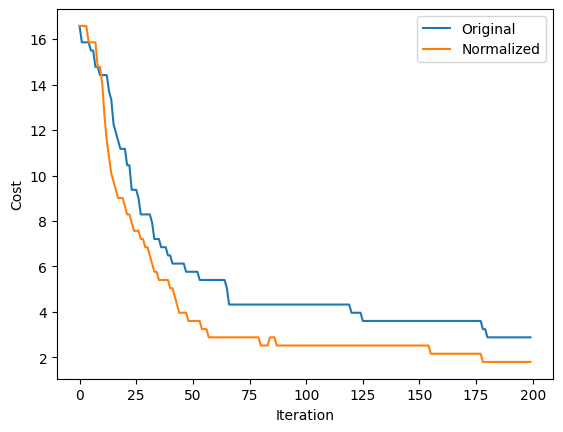

In [27]:
# We will use SGD (stochastic gradient descent) Classifier instead of LogisticRegression
# Because LogisticRegression does not permit learning rate definition
# we will use "partial_fit" instead of "fit" which is a mini-batch implementation
# but, we pass all the dataset

ALPHA = 0.01
ITMAX = 200

LRbin_orig = SGDClassifier(penalty=None,
                           warm_start=True,
                           loss='log_loss',
                           learning_rate='constant',
                           eta0=ALPHA,
                           shuffle=False
                          )
LRbin_norm = SGDClassifier(penalty=None,
                           warm_start=True,
                           loss='log_loss',
                           learning_rate='constant',
                           eta0=ALPHA,
                           shuffle=False
                          )

classes = np.unique(Ygrades)
costs_orig = []
costs_norm = []

for it in range(ITMAX):
    LRbin_orig.partial_fit(Xgrades,      Ygrades, classes=classes)
    LRbin_norm.partial_fit(Xgrades_norm, Ygrades, classes=classes)

    costs_orig.append(log_loss(Ygrades, LRbin_orig.predict(Xgrades     )))
    costs_norm.append(log_loss(Ygrades, LRbin_norm.predict(Xgrades_norm)))

# Visualization
plt.plot(costs_orig, label = 'Original')
plt.plot(costs_norm  , label = 'Normalized')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
#plt.autoscale()
plt.show()

**TODO: Analyze the results**

We note that normalized-data-based model converge faster and better than the original-data-based one in term of iterations. Faster = it reaches its optimal point where it cannot enhance the error more quickly. Better: the error when it converges is less.

1. Why faster? (explain how normalization can effect speed)
2. Why better? (explain how normalization can effect quality)

**Answers**

1. Without normalization, features with large values will have large gradients thus they dominate the updates, while smaller features change very slowly, but when the dataset is normalized, gradient descent updates all features uniformly, the optimizer takes direct steps towards the minimum.
2. Normalization ensures all features contribute proportionally, preventing large-scale features from dominating and minimizing the impact of small ones,  so we will get a well-balanced decision boundary. It also reduces calculation errors associated with large numerical values, and got a more stable and generalizable model.

#### II.1.3. Learning rate

We want to test the effect of learning rate on training convergence. This is why we trained identical models with different learning rates and then plotted the cost history for each.

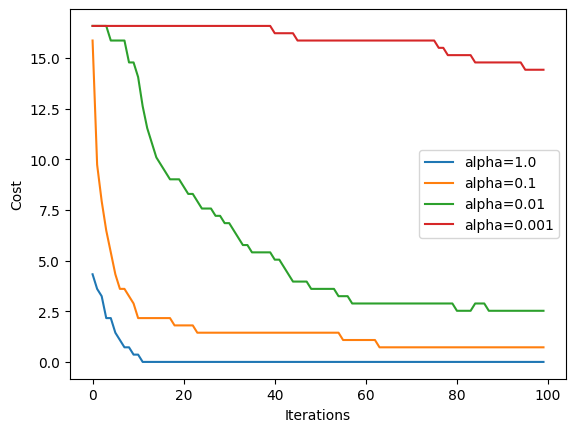

In [28]:
ITMAX  = 100
alphas = [1., 0.1, 0.01, 0.001]

classes = np.unique(Ygrades)

# For each training rate, we train a separate model
for alpha in alphas:
    # Create a new logistic regression model
    mdl = SGDClassifier(penalty=None,
                        warm_start=True,
                        loss='log_loss',
                        learning_rate='constant',
                        eta0=alpha,
                        shuffle=False
                        )
    costs = []
    for it in range(ITMAX):
        # train the model
        mdl.partial_fit(Xgrades_norm, Ygrades, classes=classes)
        costs.append(log_loss(Ygrades, mdl.predict(Xgrades_norm)))

    # Visualization
    plt.plot(costs, label = 'alpha=' + str(alpha))

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
#plt.autoscale()
plt.show()

**TODO: Analyze the results**

We note that the model converges fast when alpha=0.1. In fact, it converges around iteration 15. When alpha is smaller, the model takes more iterations to converge. For example, the model with alpha=1.0 didn't converge even after 100 iterations.

**Hypothesis:** a larger learning rate can lead to faster convergence

1. Justify this hypothesis.
2. Why we don't use a learning rate of 1 with just one iteration?
3. Why we don't use a learning rate of 1 or more with manye iterations?

**Answer**
1. A larger learning rate accelerates convergence by taking larger steps towards the optimal solution per iteration.
2. A single large step with a learning rate of 1 is unlikely to reach the optimal solution, one iteration cannot fully minimize the loss unless the problem (basically it's not sufficient)
3. Large updates can make the parameters jump over the optimal solution repeatedly rather than gradually approaching it (it may even lead to complete divergence)

so the best choice depends on the problem, and we often need to implement a learning rate scheduler to expriment with it (if the learning rate is too small we have slow converngence, if its too large it may lead to divergence, to know if a given learning rate is optimal it should provide fast convergence without instability)

### II.2. Multi-class Logistic Regression

We want to compare some methods for Multi-class Logistic Regression:
- Maximum entropy (MaxEnt)
- One-vs-Rest  (OvR)
- One-vs-One  (OvO)

In [29]:
# https://goshippo.com/blog/measure-real-size-any-python-object/
# This function will be used to get the size of a trained model
def get_size(obj, seen=None):
    """Recursively finds size of objects"""
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Important mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size(v, seen) for v in obj.values()])
        size += sum([get_size(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size(i, seen) for i in obj])
    return size

get_size({'first': 0.21, 'second': 'string'})

372

In [30]:
# A function to facilitate testing multiple models
# it depends on global variables: Xbody_train, Ybody_train, Xbody_test, Ybody_test
def multi_eval(mdls, X_trn=Xbody_train, Y_trn=Ybody_train, X_tst=Xbody_test, Y_tst=Ybody_test):
    # performance metrics
    perf = {
        'trn_time': [],
        'tst_time': [],
        'trn_acc' : [],
        'tst_acc' : [],
        'size'    : [],
    }

    for mdl in mdls:
        start_time = timeit.default_timer()
        mdl.fit(X_trn, Y_trn)
        perf['trn_time'].append(timeit.default_timer() - start_time)

        Y_pred = mdl.predict(X_trn)
        perf['trn_acc'].append(accuracy_score(Y_trn, Y_pred))

        start_time = timeit.default_timer()
        Y_pred = mdl.predict(X_tst)
        perf['tst_time'].append(timeit.default_timer() - start_time)
        perf['tst_acc'].append(accuracy_score(Y_tst, Y_pred))

        perf['size'].append(get_size(mdl))

    return perf

print('DONE')

DONE


#### II.2.1. OvR vs. MaxEnt

We want to compare OvR and MaxEnt based on accuracy. We know that the models are almost identical in term of parameters size. The difference:

| Model   |      OvR      |  MaxEnt |
| :--- |:---|:---|
| Activation function |  Logistic | Softmax |
| Cost function |  Binary cross entropy   | Cross entropy |
| Estimation | Majority vote | Maximal probability |

In [31]:
# n_jobs: use just one CPU core
# this one will be deprcated in future versions; it is faster than the next one
ovr     = LogisticRegression(n_jobs=1, max_iter=200, solver='lbfgs', penalty=None, multi_class='ovr'        )
# this one takes more size qnd time
ovr2    = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=200, penalty=None, n_jobs=1), n_jobs=1)
maxent  = LogisticRegression(n_jobs=1, max_iter=200, solver='lbfgs', penalty=None, multi_class='multinomial')
# ovrP     = LogisticRegression(n_jobs=2, max_iter=200, solver='lbfgs', penalty=None, multi_class='ovr'        )
# maxentP  = LogisticRegression(n_jobs=2, max_iter=200, solver='lbfgs', penalty=None, multi_class='multinomial')

perf = multi_eval([ovr, ovr2, maxent]) # [ovr, maxent, ovrP, maxentP]

pd.DataFrame({
    'Algorithm'     : ['OvR', 'OvR2', 'MaxEnt'], # ['OvR', 'MaxEnt', 'OvRP', 'MaxEntP']
    'Size'          : perf['size'     ],
    'Train time'    : perf['trn_time' ],
    'Test time'     : perf['tst_time' ],
    'Train Accuracy': perf['trn_acc'  ],
    'Test Accuracy' : perf['tst_acc'  ],
})

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,Algorithm,Size,Train time,Test time,Train Accuracy,Test Accuracy
0,OvR,3647,0.076935,0.000512,0.593709,0.597984
1,OvR2,6708,0.085914,0.001278,0.593709,0.597984
2,MaxEnt,3563,0.081051,0.000497,0.620123,0.624860


**TODO: Analyze the results**

We note that the size, train time, test time are almost the same.

As for the accuracy (train and test), MaXent has better quality than OvR.

1. Why (based on the boundary decision hyperplane/decision mechanism)?
2. Why (based on parameters update manner)?

**Answer**
1. In OvR, each class has its own separate decision boundary (one per class), and each classifier only distinguishes one class vs. all others, and then the final prediction is based on the majority vote (highest confidence score from the binary classifiers), then the reduced accuracy can come from the fact that some decision regions have conflicting scores, meanwhilee: the MaxEnt(softmax) use one signle decision boundary, the softmax function compares all class probabilities simultaneously and selects the most probable class.
2. Since MaxEnt updates parameters in a globally coordinated manner, it learns better feature separations and achieves higher accuracy compared to OvR, for example if a sample belongs to class A, the model not only increases confidence in class A but also actively decreases confidence in the other classes, unlike OvR where the updates for one class dont consider other classes directly,

#### II.2.3. OvR vs. OvO

We want to compare OvR and OvO using logistic regression.
We duplicated the data so we will have many samples.


In [32]:
REP = 100

Xbody_trainM = np.repeat(Xbody_train, REP, axis=0)
Ybody_trainM = np.repeat(Ybody_train, REP, axis=0)
Xbody_testM = np.repeat(Xbody_test, REP, axis=0)
Ybody_testM = np.repeat(Ybody_test, REP, axis=0)

ovr_seq = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1), n_jobs=1)
ovo_seq = OneVsOneClassifier (LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1), n_jobs=1)
ovr_con = OneVsRestClassifier(LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1), n_jobs=-1)
ovo_con = OneVsOneClassifier (LogisticRegression(solver='lbfgs', max_iter=100, penalty=None, n_jobs=1), n_jobs=-1)


perf = multi_eval([ovr_seq, ovo_seq, ovr_con, ovo_con],
                  X_trn=Xbody_trainM,
                  Y_trn=Ybody_trainM,
                  X_tst=Xbody_testM,
                  Y_tst=Ybody_testM)
# multi_eval(mdls, X_trn=Xbody_trainM, Y_trn=Ybody_trainM, X_tst=Xbody_testM, Y_tst=Ybody_testM)

pd.DataFrame({
    'Algorithm'     : ['Sequential OvR', 'Sequential OvO', 'Concurrent OvR', 'Concurrent OvO'],
    'Size'          : perf['size'     ],
    'Train time'    : perf['trn_time' ],
    'Test time'     : perf['tst_time' ],
    'Train Accuracy': perf['trn_acc'  ],
    'Test Accuracy' : perf['tst_acc'  ],
})

,Algorithm,Size,Train time,Test time,Train Accuracy,Test Accuracy
0,Sequential OvR,6692,6.677889,0.020267,0.593709,0.597984
1,Sequential OvO,8390,5.502069,0.132493,0.623390,0.627473
2,Concurrent OvR,7300,7.855315,0.020955,0.593709,0.597984
3,Concurrent OvO,9288,3.670019,0.133227,0.623390,0.627473


**TODO: Analyze the results**

1. Why the size of OvO is greater than OvR's?
1. Why OvO takes less time to train than OvR?
1. Why OvO takes more time to test than OvR?
1. Why OvO generalizes better than OvR?
1. How to modify OvR for multi-label classification?
1. How to modify OvO for multi-label classification?

**Answer**
1. because OvO trains more classifiers than OvR (C × (C-1) / 2 classifier)
1. because each classifier handles fewer samples(only on the 2 classes it compares), while OvR trains slower since each classifier has to see the full dataset.
1. OvO takes longer to test because it requires running many more classifiers per prediction
1. in OvO all classes get compared evenly in pairwise comparisons, its less affected by class imbalances, so it generalizes better since its decision boundaries are more specialized.
1. using sigmoid(multiple independet sigmoid activation functions) so we can allow multiple classes per sample, and using BCE instead of ce.
1. instead of forcing majority voting, we can define a threshold from which a sample can belong to multiple classes that are equivalent to that threshold

In [33]:
'END OF LAB ...'

'END OF LAB ...'